# Setup

In [2]:
import sys
sys.path.append('/home/arnisaf/mp-tl-study')
from functions.visualization_utils import *

## Load Data

In [3]:
# load baselines: filename!!
with open('results_jsons/baselines_freeze_True_pool_False_lr_0.001_fattest_run.json', 'r') as f:
    baselines = json.load(f)
baselines = baselines[1:]

# load results; filename
with open('results_jsons/results_freeze_True_reinit_True_pool_False_lr_0.001_fattest_run.json', 'r') as f:
    results = json.load(f)

# Run this if the first element of the results is the PARAMS dict
params = results[0]
results = results[1:]
# if not, initialize a params dict -see 3. Init params

data_dicts = baselines + results 
# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_dicts)

# Rename the columns to match the specified names
df.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

# Display the DataFrame (showing the first few rows for brevity)
df.head()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
0,0.001,0.001,-1,0,1.0,0.792635
1,0.001,0.001,-1,1,1.0,0.754166
2,0.001,0.001,-1,2,1.0,0.761777
3,0.001,0.001,-1,3,1.0,0.798190
4,0.001,0.001,-1,4,1.0,0.735857


In [33]:
# OR LOAD ARI Scores
"""with open("results_jsons/ari/ari_scores_finetuned_Fashion_to_MNIST.json", "r") as f:
    ari_scores_all = json.load(f)
df_ari = pd.DataFrame(ari_scores_all)

# Display the DataFrame (showing the first few rows for brevity)
df_ari.head()"""

# 1. The plots
See the documentation (mp-tl-study/example_visualizations.ipynb) for a full list of supported visualizations

### Experimental Plots

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

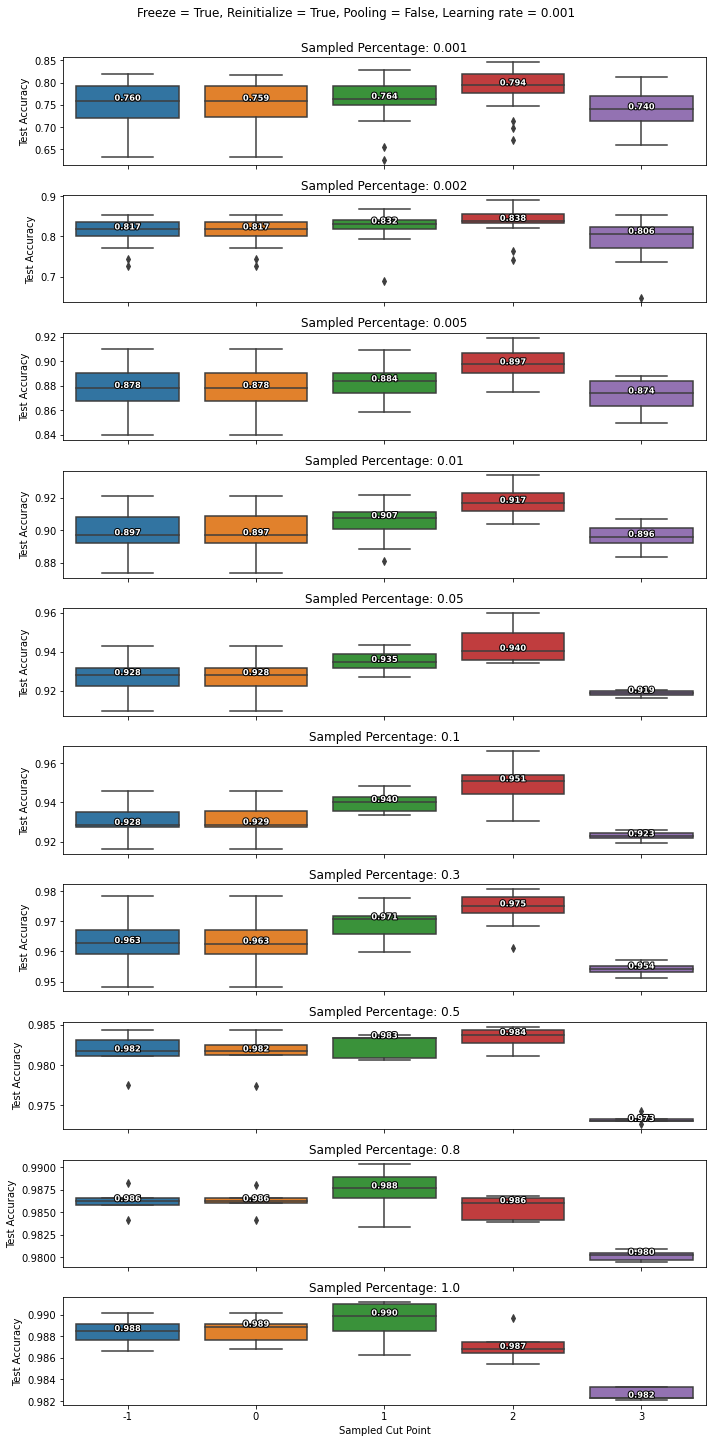

In [5]:
box_plot_percentages_experiments(df, params)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

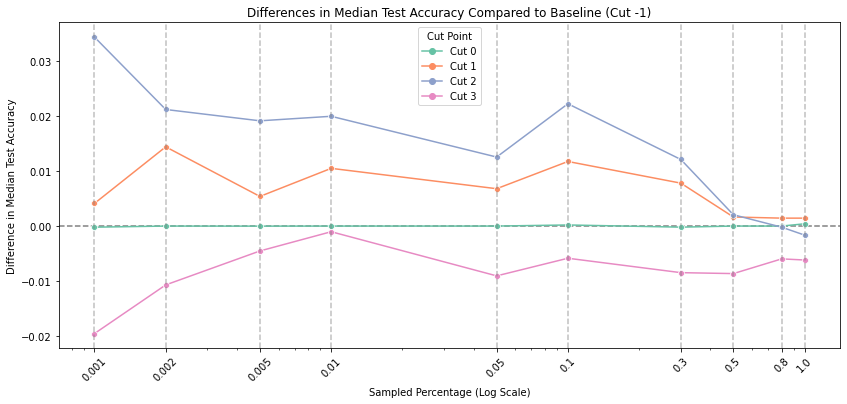

In [6]:
compare_to_baseline_line_plot(df)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

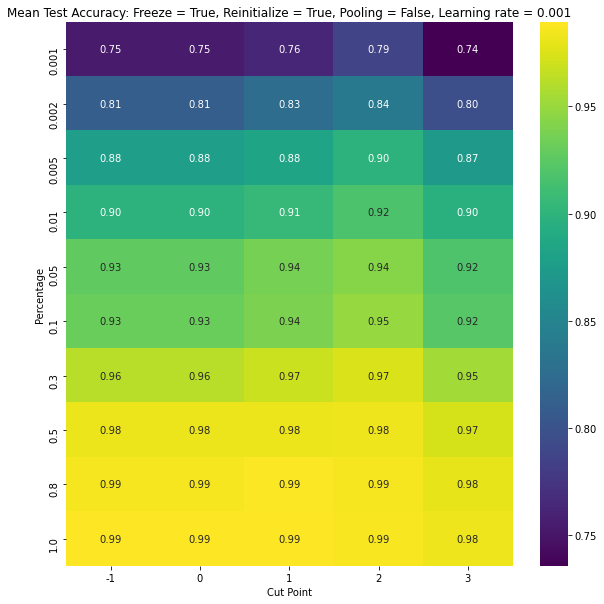

In [7]:
heatmap(df, params, figsize=(10,10))

# 2. Statistical Tests

### a. Significantly better than baseline?

In [7]:
median_baseline = df[df['Cut Point'] == -1].groupby('Percentage')['Test Accuracy'].median()
df_with_baseline = df.merge(median_baseline, on='Percentage', suffixes=('', '_baseline'))
df_with_baseline['diff_to_baseline'] = df_with_baseline['Test Accuracy'] - df_with_baseline['Test Accuracy_baseline']
df_differences = df_with_baseline[df_with_baseline['Cut Point'] != -1]

from scipy.stats import wilcoxon
import numpy as np

def perform_wilcoxon_test(data, baseline_median, cut_point):
    cut_data = data[data['Cut Point'] == cut_point]['Test Accuracy']
    baseline_data = np.full(len(cut_data), baseline_median)  # Creating an array of baseline values

    # Performing the Wilcoxon signed-rank test
    stat, p_value = wilcoxon(cut_data, baseline_data)
    return stat, p_value

# Performing the test for each cut point and sampled percentage
wilcoxon_corrected_results = []
for percentage in df_differences['Percentage'].unique():
    baseline_median = median_baseline[percentage]
    for cut_point in df_differences[df_differences['Cut Point'] != -1]['Cut Point'].unique():
        subset = df_differences[(df_differences['Percentage'] == percentage) & (df_differences['Cut Point'] == cut_point)]
        stat, p_value = perform_wilcoxon_test(subset, baseline_median, cut_point)
        wilcoxon_corrected_results.append({
            'Percentage': percentage,
            'Cut Point': cut_point,
            'statistic': stat,
            'p_value': p_value
        })

# Converting the results to a DataFrame for easier visualization
df_wilcoxon_corrected = pd.DataFrame(wilcoxon_corrected_results)


/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if ther

In [8]:
# add a columns saying if the p-value is significant or not
df_wilcoxon_corrected['is_significant'] = df_wilcoxon_corrected['p_value'] < 0.05
df_wilcoxon_corrected

,Percentage,Cut Point,statistic,p_value,is_significant
0,0.001,0,146.5,6.720752e-01,False
1,0.001,1,120.0,2.634761e-01,False
2,0.001,2,66.0,8.068800e-03,True
3,0.001,3,67.0,8.822322e-03,True
4,0.002,0,136.0,6.891415e-01,False
5,0.002,1,74.0,1.597297e-02,True
6,0.002,2,46.0,1.027107e-03,True
7,0.002,3,96.5,7.547957e-02,False
8,0.005,0,160.0,9.578450e-01,False
9,0.005,1,94.0,6.670159e-02,False


### b. Are any cuts significantly different from each other? (and also rankings)

In [10]:
# Assuming df_combined is your original DataFrame
df_differences = df[df['Cut Point'] != -1]

def perform_wilcoxon_test(group, cut_point_1, cut_point_2):
    data_1 = group[group['Cut Point'] == cut_point_1]['Test Accuracy']
    data_2 = group[group['Cut Point'] == cut_point_2]['Test Accuracy']

    # Ensure equal length by trimming or padding
    min_len = min(len(data_1), len(data_2))
    data_1, data_2 = data_1[:min_len], data_2[:min_len]

    stat, p_value = wilcoxon(data_1, data_2)
    return stat, p_value

# Perform pairwise comparison for each sampled_percentage
wilcoxon_pairwise_results = []

for percentage in df_differences['Percentage'].unique():
    group = df_differences[df_differences['Percentage'] == percentage]
    cut_points = group['Cut Point'].unique()

    for i in range(len(cut_points)):
        for j in range(i + 1, len(cut_points)):
            stat, p_value = perform_wilcoxon_test(group, cut_points[i], cut_points[j])
            wilcoxon_pairwise_results.append({
                'Percentage': percentage,
                'Cut Point 1': cut_points[i],
                'Cut Point 2': cut_points[j],
                'statistic': stat,
                'p_value': p_value
            })

# Converting the results to a DataFrame
df_wilcoxon_pairwise = pd.DataFrame(wilcoxon_pairwise_results)


/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if ther

In [11]:
# add a columns saying if the p-value is significant or not
df_wilcoxon_pairwise['is_significant'] = df_wilcoxon_pairwise['p_value'] < 0.05
df_wilcoxon_pairwise

,Percentage,Cut Point 1,Cut Point 2,statistic,p_value,is_significant
0,0.001,0,1,117.0,2.303613e-01,False
1,0.001,0,2,33.0,1.878738e-04,True
2,0.001,0,3,86.0,3.933871e-02,True
3,0.001,1,2,23.5,3.814697e-05,True
4,0.001,1,3,58.0,3.780901e-03,True
5,0.001,2,3,13.0,5.245209e-06,True
6,0.002,0,1,92.0,5.875152e-02,False
7,0.002,0,2,21.0,2.664328e-05,True
8,0.002,0,3,114.0,2.002162e-01,False
9,0.002,1,2,63.5,1.345270e-02,True


### Ranking Cuts

In [ ]:
import pandas as pd

# Assuming df_wilcoxon_pairwise and df_differences are defined as before

# Step 1: Aggregate Test Accuracy and Initialize Rankings
median_accuracy = df_differences.groupby(['sampled_percentage', 'sampled_cut_point'])['test_acc'].median()

rankings = {percentage: {} for percentage in median_accuracy.index.get_level_values(0).unique()}
for (percentage, cut_point), accuracy in median_accuracy.items():
    rankings[percentage][cut_point] = {'median_accuracy': accuracy, 'rank': None, 'group': set([cut_point])}

# Step 2: Group Cuts Based on Statistical Significance
alpha = 0.05  # Significance level

for percentage, cuts_info in rankings.items():
    for cut1, info1 in cuts_info.items():
        for cut2, info2 in cuts_info.items():
            if cut1 != cut2:
                wilcoxon_row = df_wilcoxon_pairwise[
                    (df_wilcoxon_pairwise['sampled_percentage'] == percentage) & 
                    ((df_wilcoxon_pairwise['cut_point_1'] == cut1) & (df_wilcoxon_pairwise['cut_point_2'] == cut2) |
                     (df_wilcoxon_pairwise['cut_point_1'] == cut2) & (df_wilcoxon_pairwise['cut_point_2'] == cut1))
                ]
                if not wilcoxon_row.empty and wilcoxon_row.iloc[0]['p_value'] > alpha:
                    # Merge groups if not significantly different
                    info1['group'].update(info2['group'])
                    for cut in info2['group']:
                        info1['group'].update(rankings[percentage][cut]['group'])
                    for cut in info1['group']:
                        rankings[percentage][cut]['group'] = info1['group']

# Step 3: Assign Ranks with Ties
for percentage, cuts_info in rankings.items():
    sorted_groups = sorted({frozenset(info['group']) for cut, info in cuts_info.items()}, key=lambda x: min(median_accuracy[percentage, cut] for cut in x), reverse=True)
    rank = 1
    for group in sorted_groups:
        for cut in group:
            rankings[percentage][cut]['rank'] = rank
        rank += len(group)

# Convert rankings and median accuracies to a DataFrame for easier visualization
df_rankings = pd.DataFrame([(percentage, cut, data['rank'], data['median_accuracy']) for percentage, cuts_info in rankings.items() for cut, data in cuts_info.items()],
                           columns=['sampled_percentage', 'sampled_cut_point', 'rank', 'median_accuracy'])


In [ ]:
df_rankings

### c. Are no-reinit and reinit settings significantly different from each other?
Needs readjustments

In [ ]:
# Convert to pandas DataFrames
df_no_reinit = pd.DataFrame(results_no_reinit)
df_reinit = pd.DataFrame(results_reinit)

# Merge the dataframes on data percentage, cut point, and repeat
df_merged = pd.merge(df_no_reinit, df_reinit, on=['sampled_percentage', 'sampled_cut_point', 'repeat'], suffixes=('_no_reinit', '_reinit'))

#eliminate duplicate rows 
df_merged = df_merged.drop_duplicates(subset=['sampled_percentage', 'sampled_cut_point', 'repeat'], keep='first')

# remove cut -1 and cut 3
df_merged = df_merged[df_merged['sampled_cut_point'] != -1]
df_merged = df_merged[df_merged['sampled_cut_point'] != 3]

# Group by percentage and cut point
grouped = df_merged.groupby(['sampled_percentage', 'sampled_cut_point'])

# Perform the Wilcoxon signed-rank test for each group
def perform_wilcoxon_test(group):
    test_acc_no_reinit = group['test_acc_no_reinit'].to_numpy()
    test_acc_reinit = group['test_acc_reinit'].to_numpy()

    stat, p_value = wilcoxon(test_acc_no_reinit, test_acc_reinit)
    return pd.Series({'statistic': stat, 'p_value': p_value})

# Apply the test to each group and reset index
wilcoxon_results = grouped.apply(perform_wilcoxon_test).reset_index()

# Add a column indicating significance
wilcoxon_results['is_significant'] = wilcoxon_results['p_value'] < 0.05

# Display the final results
wilcoxon_results

# 3. Extras
Don't forget to change the flags to the correct ones for the titles in the params!

In [50]:
import torch.nn as nn

percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1]
# cuts=0 means: end-to-end model if we are reinitializing
cuts = [0,1,2,3]
seed_set = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # currently not being used
batch_size = 4096
params = {
      'depth': 3,
      'width': 10, # num channels for CNN
      'hidden_dim_lin': 128,
      'activation_function': str(nn.ReLU),
      'kernel_size': 5,
      'lr_pretrain': 0.001,   
      'lr_fine_tune': 0.0001,  # CHANGE: if no layer-wise lr
      'lr_fine_tune_reinit': 0.001,         # CHANGE: if no layer-wise lr
      'lr_fine_tune_no_reinit': 0.0001,     # CHANGE: if layer-wise lr
      'num_train': 40,
      'early_stop_patience': 6,
      'save_best': False,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': False,
      'classification_report_flag': False,
      'percentages':percentages,
      'batch_size':batch_size,
      'seed_set':seed_set,
      'use_pooling': False,   # CHANGE
      'freeze': True,         # CHANGE: freeze the conv layers before the cut
      'reinit': False,         # CHANGE: reinit the conv lyers only after the cut
      'reinit_both_dense': True   # CHANGE: True for reinitialize both dense layers, False for reinit only the last dense layer
    }

### Extra 1: Split the dictionaries into baseline and fine-tuning one
only run when necessary

In [23]:
with open('results_jsons/merged_freeze_no_reinit_no_pool_lr_0.0001.json', 'r') as f:
    data_dicts = json.load(f)

baselines = [params]
results = [params]
for row in data_dicts:
    if row["sampled_cut_point"] == -1:
        baselines.append(row)
    else:
        results.append(row)

with open(f'results_jsons/baselines_freeze_{params["freeze"]}_pool_{params["use_pooling"]}_lr_{params["lr_fine_tune"]}.json', 'w') as f:
    json.dump(baselines, f)
with open(f'results_jsons/results_freeze_{params["freeze"]}_reinit_{params["reinit"]}_pool_{params["use_pooling"]}_lr_{params["lr_fine_tune"]}.json', 'w') as f:
    json.dump(results, f)

### Extra 2: Parse Cell outputs
Works only with the standart cell output -see the next cell

In [1]:
# copy the cell output here
out = """

Sampled Percentage: 0.001, Sampled Cut Point: 4, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.3200, Test Accuracy: 0.3647

Sampled Percentage: 0.001, Sampled Cut Point: 4, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.1600, Test Accuracy: 0.2995

Sampled Percentage: 0.001, Sampled Cut Point: 4, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.3200, Test Accuracy: 0.2580

Sampled Percentage: 0.001, Sampled Cut Point: 4, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.2400, Test Accuracy: 0.2736

Sampled Percentage: 0.001, Sampled Cut Point: 4, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.3200, Test Accuracy: 0.3207

Sampled Percentage: 0.001, Sampled Cut Point: 4, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 0.1600, Test Accuracy: 0.1528

Sampled Percentage: 0.001, Sampled Cut Point: 4, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 0.3200, Test Accuracy: 0.4108

Sampled Percentage: 0.001, Sampled Cut Point: 4, Lr: 0.001, Repeat: 7
Early stopping invoked.
Training Accuracy: 0.1600, Test Accuracy: 0.2448

Sampled Percentage: 0.001, Sampled Cut Point: 4, Lr: 0.001, Repeat: 8
Early stopping invoked.
Training Accuracy: 0.2000, Test Accuracy: 0.1954

Sampled Percentage: 0.001, Sampled Cut Point: 4, Lr: 0.001, Repeat: 9
Early stopping invoked.
Training Accuracy: 0.2400, Test Accuracy: 0.2742

Sampled Percentage: 0.001, Sampled Cut Point: 4, Lr: 0.001, Repeat: 10
Early stopping invoked.
Training Accuracy: 0.3600, Test Accuracy: 0.3925

Sampled Percentage: 0.001, Sampled Cut Point: 4, Lr: 0.001, Repeat: 11
Early stopping invoked.
Training Accuracy: 0.2000, Test Accuracy: 0.1366

Sampled Percentage: 0.001, Sampled Cut Point: 4, Lr: 0.001, Repeat: 12
Early stopping invoked.
Training Accuracy: 0.3200, Test Accuracy: 0.3164

Sampled Percentage: 0.001, Sampled Cut Point: 4, Lr: 0.001, Repeat: 13
Early stopping invoked.
Training Accuracy: 0.3600, Test Accuracy: 0.3833

Sampled Percentage: 0.001, Sampled Cut Point: 4, Lr: 0.001, Repeat: 14
Early stopping invoked.
Training Accuracy: 0.2000, Test Accuracy: 0.1854

Sampled Percentage: 0.001, Sampled Cut Point: 4, Lr: 0.001, Repeat: 15
Early stopping invoked.
Training Accuracy: 0.2000, Test Accuracy: 0.1847

Sampled Percentage: 0.001, Sampled Cut Point: 4, Lr: 0.001, Repeat: 16
Early stopping invoked.
Training Accuracy: 0.2800, Test Accuracy: 0.2557

Sampled Percentage: 0.001, Sampled Cut Point: 4, Lr: 0.001, Repeat: 17
Early stopping invoked.
Training Accuracy: 0.2000, Test Accuracy: 0.2265

Sampled Percentage: 0.001, Sampled Cut Point: 4, Lr: 0.001, Repeat: 18
Early stopping invoked.
Training Accuracy: 0.0800, Test Accuracy: 0.1465

Sampled Percentage: 0.001, Sampled Cut Point: 4, Lr: 0.001, Repeat: 19
Early stopping invoked.
Training Accuracy: 0.4000, Test Accuracy: 0.3682

Sampled Percentage: 0.002, Sampled Cut Point: 4, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.4000, Test Accuracy: 0.3621

Sampled Percentage: 0.002, Sampled Cut Point: 4, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.1600, Test Accuracy: 0.2952

Sampled Percentage: 0.002, Sampled Cut Point: 4, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.2400, Test Accuracy: 0.2629

Sampled Percentage: 0.002, Sampled Cut Point: 4, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.2800, Test Accuracy: 0.2715

Sampled Percentage: 0.002, Sampled Cut Point: 4, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.2600, Test Accuracy: 0.3234

Sampled Percentage: 0.002, Sampled Cut Point: 4, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 0.1800, Test Accuracy: 0.1528

Sampled Percentage: 0.002, Sampled Cut Point: 4, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 0.3800, Test Accuracy: 0.4069

Sampled Percentage: 0.002, Sampled Cut Point: 4, Lr: 0.001, Repeat: 7
Early stopping invoked.
Training Accuracy: 0.2400, Test Accuracy: 0.2446

Sampled Percentage: 0.002, Sampled Cut Point: 4, Lr: 0.001, Repeat: 8
Early stopping invoked.
Training Accuracy: 0.1800, Test Accuracy: 0.1954

Sampled Percentage: 0.002, Sampled Cut Point: 4, Lr: 0.001, Repeat: 9
Early stopping invoked.
Training Accuracy: 0.2800, Test Accuracy: 0.2617

Sampled Percentage: 0.002, Sampled Cut Point: 4, Lr: 0.001, Repeat: 10
Early stopping invoked.
Training Accuracy: 0.4000, Test Accuracy: 0.4129

Sampled Percentage: 0.002, Sampled Cut Point: 4, Lr: 0.001, Repeat: 11
Early stopping invoked.
Training Accuracy: 0.1800, Test Accuracy: 0.1635

Sampled Percentage: 0.002, Sampled Cut Point: 4, Lr: 0.001, Repeat: 12
Early stopping invoked.
Training Accuracy: 0.2800, Test Accuracy: 0.3137

Sampled Percentage: 0.002, Sampled Cut Point: 4, Lr: 0.001, Repeat: 13
Early stopping invoked.
Training Accuracy: 0.3000, Test Accuracy: 0.3878

Sampled Percentage: 0.002, Sampled Cut Point: 4, Lr: 0.001, Repeat: 14
Early stopping invoked.
Training Accuracy: 0.2000, Test Accuracy: 0.1854

Sampled Percentage: 0.002, Sampled Cut Point: 4, Lr: 0.001, Repeat: 15
Early stopping invoked.
Training Accuracy: 0.1800, Test Accuracy: 0.1821

Sampled Percentage: 0.002, Sampled Cut Point: 4, Lr: 0.001, Repeat: 16
Early stopping invoked.
Training Accuracy: 0.2400, Test Accuracy: 0.2629

Sampled Percentage: 0.002, Sampled Cut Point: 4, Lr: 0.001, Repeat: 17
Early stopping invoked.
Training Accuracy: 0.2000, Test Accuracy: 0.2393

Sampled Percentage: 0.002, Sampled Cut Point: 4, Lr: 0.001, Repeat: 18
Training Accuracy: 0.6400, Test Accuracy: 0.5351

Sampled Percentage: 0.002, Sampled Cut Point: 4, Lr: 0.001, Repeat: 19
Early stopping invoked.
Training Accuracy: 0.3400, Test Accuracy: 0.3742

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.3769, Test Accuracy: 0.3997

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.2077, Test Accuracy: 0.2971

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.2846, Test Accuracy: 0.2753

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.2538, Test Accuracy: 0.2742

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.2615, Test Accuracy: 0.3234

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 0.1846, Test Accuracy: 0.1528

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 0.4462, Test Accuracy: 0.3946

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 7
Early stopping invoked.
Training Accuracy: 0.2615, Test Accuracy: 0.2469

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 8
Early stopping invoked.
Training Accuracy: 0.1923, Test Accuracy: 0.1954

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 9
Early stopping invoked.
Training Accuracy: 0.2385, Test Accuracy: 0.2512

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 10
Early stopping invoked.
Training Accuracy: 0.4615, Test Accuracy: 0.4014

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 11
Early stopping invoked.
Training Accuracy: 0.1462, Test Accuracy: 0.1613

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 12
Early stopping invoked.
Training Accuracy: 0.3231, Test Accuracy: 0.3154

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 13
Early stopping invoked.
Training Accuracy: 0.4077, Test Accuracy: 0.3847

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 14
Early stopping invoked.
Training Accuracy: 0.1923, Test Accuracy: 0.1854

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 15
Early stopping invoked.
Training Accuracy: 0.1692, Test Accuracy: 0.1849

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 16
Early stopping invoked.
Training Accuracy: 0.2769, Test Accuracy: 0.2730

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 17
Early stopping invoked.
Training Accuracy: 0.1692, Test Accuracy: 0.2230

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 18
Training Accuracy: 0.5923, Test Accuracy: 0.5205

Sampled Percentage: 0.005, Sampled Cut Point: 4, Lr: 0.001, Repeat: 19
Early stopping invoked.
Training Accuracy: 0.4154, Test Accuracy: 0.3913

Sampled Percentage: 0.01, Sampled Cut Point: 4, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.4154, Test Accuracy: 0.4077

Sampled Percentage: 0.01, Sampled Cut Point: 4, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.2500, Test Accuracy: 0.2950

Sampled Percentage: 0.01, Sampled Cut Point: 4, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.2731, Test Accuracy: 0.2703

Sampled Percentage: 0.01, Sampled Cut Point: 4, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.2538, Test Accuracy: 0.2730

Sampled Percentage: 0.01, Sampled Cut Point: 4, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.2808, Test Accuracy: 0.3226

Sampled Percentage: 0.01, Sampled Cut Point: 4, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 0.1769, Test Accuracy: 0.1528

Sampled Percentage: 0.01, Sampled Cut Point: 4, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 0.4692, Test Accuracy: 0.4014

Sampled Percentage: 0.01, Sampled Cut Point: 4, Lr: 0.001, Repeat: 7
Early stopping invoked.
Training Accuracy: 0.2808, Test Accuracy: 0.2469

Sampled Percentage: 0.01, Sampled Cut Point: 4, Lr: 0.001, Repeat: 8
Early stopping invoked.
Training Accuracy: 0.1923, Test Accuracy: 0.1954

Sampled Percentage: 0.01, Sampled Cut Point: 4, Lr: 0.001, Repeat: 9
Early stopping invoked.
Training Accuracy: 0.2577, Test Accuracy: 0.2574

Sampled Percentage: 0.01, Sampled Cut Point: 4, Lr: 0.001, Repeat: 10
Early stopping invoked.
Training Accuracy: 0.4346, Test Accuracy: 0.4020

Sampled Percentage: 0.01, Sampled Cut Point: 4, Lr: 0.001, Repeat: 11
Early stopping invoked.
Training Accuracy: 0.1538, Test Accuracy: 0.1566

Sampled Percentage: 0.01, Sampled Cut Point: 4, Lr: 0.001, Repeat: 12
Early stopping invoked.
Training Accuracy: 0.3115, Test Accuracy: 0.3121

Sampled Percentage: 0.01, Sampled Cut Point: 4, Lr: 0.001, Repeat: 13
Early stopping invoked.
Training Accuracy: 0.4154, Test Accuracy: 0.3935

Sampled Percentage: 0.01, Sampled Cut Point: 4, Lr: 0.001, Repeat: 14
Early stopping invoked.
Training Accuracy: 0.1923, Test Accuracy: 0.1854

Sampled Percentage: 0.01, Sampled Cut Point: 4, Lr: 0.001, Repeat: 15
Early stopping invoked.
Training Accuracy: 0.1923, Test Accuracy: 0.1825

Sampled Percentage: 0.01, Sampled Cut Point: 4, Lr: 0.001, Repeat: 16
Early stopping invoked.
Training Accuracy: 0.2808, Test Accuracy: 0.2746

Sampled Percentage: 0.01, Sampled Cut Point: 4, Lr: 0.001, Repeat: 17
Early stopping invoked.
Training Accuracy: 0.3231, Test Accuracy: 0.3314

Sampled Percentage: 0.01, Sampled Cut Point: 4, Lr: 0.001, Repeat: 18
Training Accuracy: 0.5769, Test Accuracy: 0.5349

Sampled Percentage: 0.01, Sampled Cut Point: 4, Lr: 0.001, Repeat: 19
Early stopping invoked.
Training Accuracy: 0.4115, Test Accuracy: 0.4005

Sampled Percentage: 0.05, Sampled Cut Point: 4, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.3917, Test Accuracy: 0.4116

Sampled Percentage: 0.05, Sampled Cut Point: 4, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.2826, Test Accuracy: 0.2929

Sampled Percentage: 0.05, Sampled Cut Point: 4, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.2773, Test Accuracy: 0.2594

Sampled Percentage: 0.05, Sampled Cut Point: 4, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.2697, Test Accuracy: 0.2730

Sampled Percentage: 0.05, Sampled Cut Point: 4, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.2955, Test Accuracy: 0.3230

Sampled Percentage: 0.05, Sampled Cut Point: 4, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 0.1659, Test Accuracy: 0.1528

Sampled Percentage: 0.05, Sampled Cut Point: 4, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 0.4235, Test Accuracy: 0.4018

Sampled Percentage: 0.05, Sampled Cut Point: 4, Lr: 0.001, Repeat: 7
Early stopping invoked.
Training Accuracy: 0.2538, Test Accuracy: 0.2479

Sampled Percentage: 0.05, Sampled Cut Point: 4, Lr: 0.001, Repeat: 8
Early stopping invoked.
Training Accuracy: 0.1955, Test Accuracy: 0.1954

Sampled Percentage: 0.05, Sampled Cut Point: 4, Lr: 0.001, Repeat: 9
Early stopping invoked.
Training Accuracy: 0.2773, Test Accuracy: 0.2787

Sampled Percentage: 0.05, Sampled Cut Point: 4, Lr: 0.001, Repeat: 10
Early stopping invoked.
Training Accuracy: 0.4023, Test Accuracy: 0.4038

Sampled Percentage: 0.05, Sampled Cut Point: 4, Lr: 0.001, Repeat: 11
Early stopping invoked.
Training Accuracy: 0.1364, Test Accuracy: 0.1553

Sampled Percentage: 0.05, Sampled Cut Point: 4, Lr: 0.001, Repeat: 12
Early stopping invoked.
Training Accuracy: 0.3053, Test Accuracy: 0.3106

Sampled Percentage: 0.05, Sampled Cut Point: 4, Lr: 0.001, Repeat: 13
Early stopping invoked.
Training Accuracy: 0.3977, Test Accuracy: 0.3820

Sampled Percentage: 0.05, Sampled Cut Point: 4, Lr: 0.001, Repeat: 14
Early stopping invoked.
Training Accuracy: 0.1947, Test Accuracy: 0.1854

Sampled Percentage: 0.1, Sampled Cut Point: 4, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.3955, Test Accuracy: 0.4114

Sampled Percentage: 0.1, Sampled Cut Point: 4, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.2866, Test Accuracy: 0.2917

Sampled Percentage: 0.1, Sampled Cut Point: 4, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.2786, Test Accuracy: 0.2590

Sampled Percentage: 0.1, Sampled Cut Point: 4, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.2715, Test Accuracy: 0.2724

Sampled Percentage: 0.1, Sampled Cut Point: 4, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.2922, Test Accuracy: 0.3236

Sampled Percentage: 0.1, Sampled Cut Point: 4, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 0.1667, Test Accuracy: 0.1528

Sampled Percentage: 0.1, Sampled Cut Point: 4, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 0.4348, Test Accuracy: 0.4088

Sampled Percentage: 0.1, Sampled Cut Point: 4, Lr: 0.001, Repeat: 7
Early stopping invoked.
Training Accuracy: 0.2480, Test Accuracy: 0.2479

Sampled Percentage: 0.1, Sampled Cut Point: 4, Lr: 0.001, Repeat: 8
Early stopping invoked.
Training Accuracy: 0.1943, Test Accuracy: 0.1954

Sampled Percentage: 0.1, Sampled Cut Point: 4, Lr: 0.001, Repeat: 9
Early stopping invoked.
Training Accuracy: 0.2779, Test Accuracy: 0.2750

Sampled Percentage: 0.1, Sampled Cut Point: 4, Lr: 0.001, Repeat: 10
Early stopping invoked.
Training Accuracy: 0.4030, Test Accuracy: 0.4028

Sampled Percentage: 0.1, Sampled Cut Point: 4, Lr: 0.001, Repeat: 11
Early stopping invoked.
Training Accuracy: 0.1448, Test Accuracy: 0.1561

Sampled Percentage: 0.1, Sampled Cut Point: 4, Lr: 0.001, Repeat: 12
Early stopping invoked.
Training Accuracy: 0.3070, Test Accuracy: 0.3106

Sampled Percentage: 0.1, Sampled Cut Point: 4, Lr: 0.001, Repeat: 13
Early stopping invoked.
Training Accuracy: 0.3962, Test Accuracy: 0.3833

Sampled Percentage: 0.1, Sampled Cut Point: 4, Lr: 0.001, Repeat: 14
Early stopping invoked.
Training Accuracy: 0.1936, Test Accuracy: 0.1854
"""

In [4]:
import re

out = re.sub(r'Early stopping invoked.\n', '', out)

results = []
for line in out.split("\n\n"):
    terms = re.sub(r"[:|,|\n]", "\t", line).split("\t")
    terms = [term for term in terms if len(term)>0 and term != ""]
    if len(terms) != 12:
        print(terms)
        print(line)
    else:
        results.append({"lr":0.0001, "sampled_percentage":float(terms[1].strip()), "sampled_cut_point":int(terms[3].strip()), "repeat":int(terms[7].strip()), "train_acc":float(terms[9].strip()), "test_acc":float(terms[11].strip())})

[]



In [20]:
# naming!
params_tmp = copy.deepcopy(params)
params_tmp["activation_function"] = str(params_tmp["activation_function"])
results = [params_tmp] + results
with open(f'results_jsons/results_freeze_True_reinit_False_pool_False_lr_0.001_seed_subsamples_load_pretrained_model_4_cuts.json', 'w') as f:
    json.dump(results, f)

In [8]:
# or append at the end of some other results
# load results; filename
with open('results_jsons/results_freeze_True_reinit_False_pool_False_lr_0.001_seed_subsamples_load_pretrained_model.json', 'r') as f:
    results_old = json.load(f)
results_old.extend(results)

In [11]:
with open(f'results_jsons/results_freeze_True_reinit_False_pool_False_lr_0.001_seed_subsamples_load_pretrained_model_4_cuts.json', 'w') as f:
    json.dump(results_old, f)

### Extra 3: Merge json files

In [3]:
# read all you want to merge (assuming the first element is the params and same for all)

with open('results_jsons/results_freeze_True_reinit_True_pool_False_lr_0.001_0.001_to_0.002.json', 'r') as f:
    results1 = json.load(f)
with open('results_jsons/results_freeze_True_reinit_True_pool_False_lr_0.001_0.005.json', 'r') as f:
    results2 = json.load(f)
with open('results_jsons/results_freeze_True_reinit_True_pool_False_lr_0.001_0.01.json', 'r') as f:
    results3 = json.load(f)
with open('results_jsons/results_freeze_True_reinit_True_pool_False_lr_0.001_0.05.json', 'r') as f:
    results4 = json.load(f)
with open('results_jsons/results_freeze_True_reinit_True_pool_False_lr_0.001_0.1.json', 'r') as f:
    results5 = json.load(f)
with open('results_jsons/results_freeze_True_reinit_True_pool_False_lr_0.001_0.3.json', 'r') as f:
    results6 = json.load(f)
with open('results_jsons/results_freeze_True_reinit_True_pool_False_lr_0.001_0.5.json', 'r') as f:
    results7 = json.load(f)
with open('results_jsons/results_freeze_True_reinit_True_pool_False_lr_0.001_0.8.json', 'r') as f:
    results8 = json.load(f)
with open('results_jsons/results_freeze_True_reinit_True_pool_False_lr_0.001_1.json', 'r') as f:
    results9 = json.load(f)

params = results1[0]

results = [params] + results1[1:] + results2[1:] + results3[1:] + results4[1:] + results5[1:] + results6[1:] + results7[1:] + results8[1:] + results9[1:]

# save
with open(f'results_jsons/results_freeze_True_reinit_True_pool_False_lr_0.001_fattest_run.json', 'w') as f:
    json.dump(results, f)

In [2]:
# read all you want to merge (assuming the first element is the params and same for all)

with open('results_jsons/baselines_freeze_True_pool_False_lr_0.001_0.001_to_0.002.json', 'r') as f:
    baselines1 = json.load(f)
with open('results_jsons/baselines_freeze_True_pool_False_lr_0.001_0.005_to_0.01.json', 'r') as f:
    baselines2 = json.load(f)
with open('results_jsons/baselines_freeze_True_pool_False_lr_0.001_0.05_to_0.3.json', 'r') as f:
    baselines3 = json.load(f)
with open('results_jsons/baselines_freeze_True_pool_False_lr_0.001_0.5.json', 'r') as f:
    baselines4 = json.load(f)
with open('results_jsons/baselines_freeze_True_pool_False_lr_0.001_0.8_to_1.json', 'r') as f:
    baselines5 = json.load(f)

params = baselines1[0]

baselines = [params] + baselines1[1:] + baselines2[1:] + baselines3[1:] + baselines4[1:] + baselines5[1:]

# save
with open(f'results_jsons/baselines_freeze_True_pool_False_lr_0.001_fattest_run.json', 'w') as f:
    json.dump(baselines, f)

In [11]:
for i in range(len(baselines)):
    baselines[i]["sampled_cut_point"] = -1

In [14]:
baselines = [params] + baselines

# save
with open(f'results_jsons/baselines_freeze_True_pool_False_lr_0.001_fattest_run.json', 'w') as f:
    json.dump(baselines, f)